In [143]:
# import libraries and modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for splitting dataset into train, val and test
from sklearn.model_selection import train_test_split

# for dataset augumentations
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for controling learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# import custom modules
from utils import *
from models import *

# config autoreload
%load_ext autoreload
%autoreload 2

# config matplotlib inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# unzipping directory
import zipfile

# path to the train zip file
train_zip_path = r"datasets\train.zip"

# path to train directory
train = r"datasets\train"

# extract the zip file
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train)

In [144]:
train_path = r"datasets\train\train"


In [ ]:
# Remove corrupted images from the dataset
train_path = r"datasets\train\train"

for filename in os.listdir(train_path):
    file_path = os.path.join(train_path, filename)
    if not validate_image(file_path):
        os.remove(file_path)

Corrupted image: datasets\train\train\cat.9030.jpg - Error: cannot identify image file 'R:\\cat_dog_classification\\datasets\\train\\train\\cat.9030.jpg'


In [60]:
# create a dataframe dataset from the filenames and labels
filenames = os.listdir(train_path)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})
data.to_csv(r"datasets\train_label.csv", index=False)

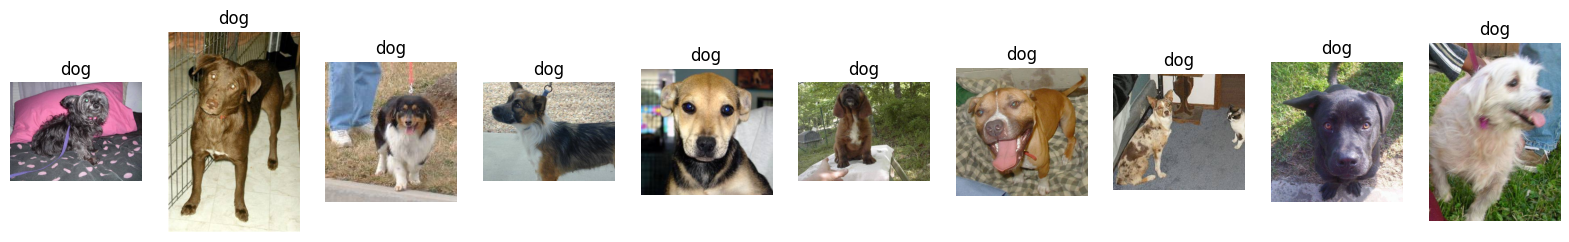

In [65]:
# visualize the first 10 images
visualize_image(train_path, "dog")

In [145]:
dataset = pd.read_csv(r"datasets\train_labels.csv")

In [146]:
# split datasets into train (80%), test(10%) and validation(10) sets
x_train, x_temp = train_test_split(dataset, test_size=0.2, train_size=0.8, stratify=dataset['label'], random_state=42)
x_test, x_val =  train_test_split(x_temp, test_size=0.5, stratify=x_temp['label'], random_state = 42)

# datasets classes
class_name = (x_train['label'].unique()).tolist()

In [147]:
print(f"Train set: {x_train.shape[0]} images")
print(f"Test set: {x_test.shape[0]} images")
print(f"Validation set: {x_val.shape[0]} images")
print(f"Classes: {class_name}")

Train set: 19999 images
Test set: 2500 images
Validation set: 2500 images
Classes: [0, 1]


In [148]:
# configure model parameters
image_size = 128
image_channel = 3
bat_size = 64

In [149]:
# Define image data generator for train and test sets augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [151]:
x_train['label'] = x_train['label'].astype(str)
train_generator = train_datagen.flow_from_dataframe(x_train,
                                                    directory = None, # use None if x_train contains absolute paths
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode='sparse' # use 'categorical' for string labels
                                                   )

Found 19998 validated image filenames belonging to 2 classes.


j:\Python\Python3.12.5\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [152]:
x_val['label'] = x_val['label'].astype(str)
val_generator = test_datagen.flow_from_dataframe(x_val, 
                                                 directory = None, # use None if x_val contains absolute paths
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode = 'sparse' # use categorical for string labels 
                                                )

Found 2500 validated image filenames belonging to 2 classes.


In [153]:
x_test['label'] = x_test['label'].astype(str)
val_generator = test_datagen.flow_from_dataframe(x_test, 
                                                 directory = None, # use None if x_val contains absolute paths
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode = 'sparse' # use sparse for categorical for stringlabels
                                                )

Found 2500 validated image filenames belonging to 2 classes.


In [154]:
# define model
model = cat_dog_model(image_size, image_channel)

j:\Python\Python3.12.5\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
# model architecuter summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [156]:
# control learning rate by consifering val_acc or val_loss
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

# stop training when monitor param has been maintained
early_stoping = EarlyStopping(
                    monitor='val_loss',
                    patience= 3,
                    restore_best_weights=True,
                    verbose=1)


In [101]:
# visualizing parameters while training with tensorboard
import datetime
import tensorflow.keras as tfk

%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [157]:
# compiling models
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [107]:
history = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[early_stoping,learning_rate_reduction, tensorboard_callback],
                    epochs = 1,
                   )

j:\Python\Python3.12.5\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.6282 - loss: 0.7568 - val_accuracy: 0.5016 - val_loss: 1.4515 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# lunch tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# saving model
model.save('cat_dog_model.h5')


In [ ]:
%reload_ext autoreload
visulaize_ouput(history)

In [158]:

# model evaluation on validation set
model = tfk.models.load_model('cat_dog_model.h5')
model.evaluate(val_generator)

j:\Python\Python3.12.5\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9108 - loss: 0.1949


[0.20082730054855347, 0.909600019454956]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00156479]]
0
0.0015647918


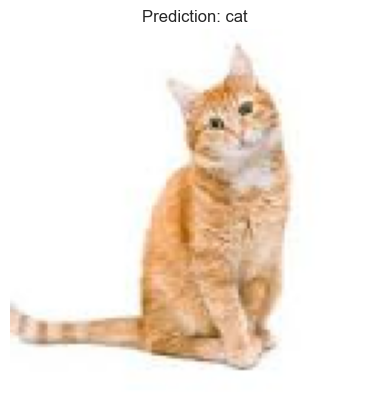

In [ ]:
# function to predict image
predictor(model, r'download.jpg', classes=['cat', 'dog'])